In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
dataset_dir = './dataset/training'

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

In [3]:
%%script false --no-raise-error
num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


In [4]:
SEED = 19011997
SPLIT = 0.1
BATCH_SIZE = 128
IMG_SIZE = (256,256)
IMG_SIZE_WITH_CHANNELS = IMG_SIZE + (3,)

## Dataset statistics

Total count: 17728
Apple count: 988
Blueberry count: 467
Cherry count: 583
Corn count: 1206
Grape count: 1458
Orange count: 1748
Peach count: 977
Pepper count: 765
Potato count: 716
Raspberry count: 264
Soybean count: 1616
Squash count: 574
Strawberry count: 673
Tomato count: 5693


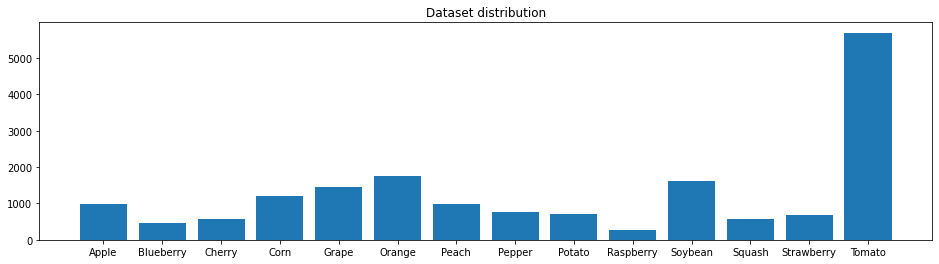

In [5]:
import pathlib

dataset_dir_path = pathlib.Path(dataset_dir)
images_count_total = len(list(dataset_dir_path.glob('*/*.jpg')))
print('Total count: {}'.format(images_count_total))
images_count = {}
for label in labels:
    count = len(list(dataset_dir_path.glob('{}/*.jpg'.format(label))))
    images_count[label] = count
    print('{} count: {}'.format(label, count))
plt.figure(figsize=(16,4))
plt.bar(range(len(labels)), list(images_count.values()))
plt.xticks(range(len(labels)), labels)
plt.title('Dataset distribution')
plt.show()

In [6]:
max_class = max(images_count.values())
class_weights = {}
i = 0
for k,v in images_count.items():
    class_weights[i] = max_class/v
    i += 1
print(class_weights)

{0: 5.762145748987854, 1: 12.190578158458244, 2: 9.76500857632933, 3: 4.720563847429519, 4: 3.904663923182442, 5: 3.2568649885583523, 6: 5.827021494370522, 7: 7.441830065359477, 8: 7.951117318435754, 9: 21.564393939393938, 10: 3.5228960396039604, 11: 9.918118466898955, 12: 8.459138187221397, 13: 1.0}


## Load data

[tutorial](https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility)

In [7]:
import tensorflow as tf

def import_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=labels,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=SPLIT,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )

dataset_training = import_dataset('training')
dataset_validation = import_dataset('validation')

Found 17728 files belonging to 14 classes.
Using 15956 files for training.
Found 17728 files belonging to 14 classes.
Using 1772 files for validation.


**Dataset shape** `((batch, width?, height?, channels), (batch, classes))`

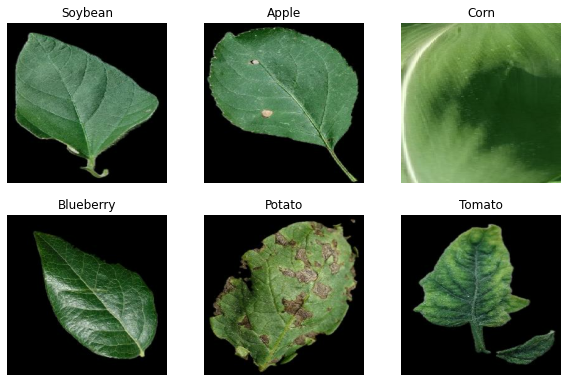

In [8]:
plt.figure(figsize=(10, 10))
for images, onehot in dataset_training.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(np.array(onehot[i]), axis=0)
    plt.title(labels[index])
    plt.axis("off")

[tutorial](https://keras.io/examples/vision/image_classification_from_scratch/)

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.5, fill_mode='constant') # oppure "nearest"
    ]
)

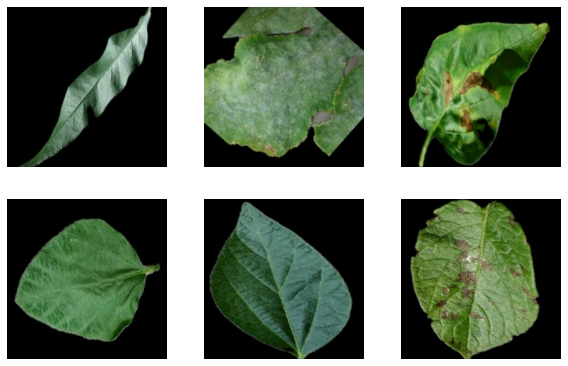

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in dataset_training.take(1):
  for i in range(6):
    augim = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augim[i].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
def make_base(input_Shape):
    # Base
    base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_Shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.

    base_model.trainable = False

    return base_model

In [12]:
def make_model(input_shape, num_classes):
    base_model = make_base(input_shape)

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    x = tf.keras.layers.Rescaling(1./255)(x)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [13]:
model = make_model(IMG_SIZE_WITH_CHANNELS, len(labels))

83697664/83683744 [==============================] - 12s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                             

In [15]:
EPOCHS = 25
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    dataset_training,
    epochs=EPOCHS,
    validation_data=dataset_validation,
    class_weight=class_weights,
    #callbacks=[callback],
)

Epoch 1/25
125/125 [==============================] - 63s 434ms/step - loss: 0.9254 - accuracy: 0.5332 - val_loss: 0.1401 - val_accuracy: 0.7602
Epoch 2/25
125/125 [==============================] - 51s 408ms/step - loss: 0.5144 - accuracy: 0.7838 - val_loss: 0.1010 - val_accuracy: 0.8318
Epoch 3/25
125/125 [==============================] - 51s 409ms/step - loss: 0.4014 - accuracy: 0.8343 - val_loss: 0.0839 - val_accuracy: 0.8657
Epoch 4/25
125/125 [==============================] - 48s 380ms/step - loss: 0.3399 - accuracy: 0.8565 - val_loss: 0.0745 - val_accuracy: 0.8854
Epoch 5/25
125/125 [==============================] - 47s 375ms/step - loss: 0.3005 - accuracy: 0.8743 - val_loss: 0.0656 - val_accuracy: 0.9012
Epoch 6/25
125/125 [==============================] - 46s 370ms/step - loss: 0.2726 - accuracy: 0.8840 - val_loss: 0.0613 - val_accuracy: 0.9080
Epoch 7/25
125/125 [==============================] - 48s 382ms/step - loss: 0.2491 - accuracy: 0.8948 - val_loss: 0.0570 - val_ac

In [18]:
model.save('./models/model.h5')

In [29]:
y_prob = model.predict(dataset_validation.take(1))
a = dataset_validation.take(1)
b = list(a)
y_classes = y_prob.argmax(axis=-1)
#predicted_label = labels[y_classes]#
b

[(<tf.Tensor: shape=(128, 256, 256, 3), dtype=float32, numpy=
  array([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          ...,
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 